In [1]:

!pip install scikit-learn imbalanced-learn evaluate transformers "datasets>=2.14.5" "accelerate>=0.27" mlflow tensorflow torch torchvision matplotlib pandas numpy


In [2]:
!pip install tf-keras

In [10]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [11]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Define the path to the dataset
dataset_path = Path('C:/Users/Manveen/PycharmProjects/AsanaBot/yoga-pose-classification-dataset/')

# # Verify the path exists
if not dataset_path.exists():
    print(f"Dataset path '{dataset_path}' does not exist.")
else:
    # Print directory contents for verification
    print(f"Contents of the dataset directory:")
    for subdir in dataset_path.iterdir():
        if subdir.is_dir():  # Only process directories
            print(f"Processing subdirectory: {subdir}")
            for file in subdir.glob('*.*'):  # Adjust pattern if necessary
                print(f"Processing file: {file}")  # Print each file being processed
                label = subdir.name  # Use the subdirectory name as the label
                labels.append(label)  # Add the label to the list
                file_names.append(str(file))  # Add the file path to the list

    # Print the total number of file names and labels
    print(len(file_names), len(labels))

    # Create a pandas dataframe from the collected file names and labels
    df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

In [13]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
df = pd.read_csv('yoga_pose_classification.csv')
print(df.shape)

(2177, 2)


In [14]:
df.head()

,image,label
0,C:\Users\Manveen\PycharmProjects\AsanaBot\yoga...,Bridge-Pose
1,C:\Users\Manveen\PycharmProjects\AsanaBot\yoga...,Bridge-Pose
2,C:\Users\Manveen\PycharmProjects\AsanaBot\yoga...,Bridge-Pose
3,C:\Users\Manveen\PycharmProjects\AsanaBot\yoga...,Bridge-Pose
4,C:\Users\Manveen\PycharmProjects\AsanaBot\yoga...,Bridge-Pose


In [15]:
df['label'].unique()

array(['Bridge-Pose', 'Child-Pose', 'Cobra-Pose', 'Downward-Dog-Pose',
       'Pigeon-Pose', 'Standing-Mountain-Pose', 'Tree-Pose',
       'Triangle-Pose', 'Warrior-Pose'], dtype=object)

In [16]:

y = df[['label']]


df = df.drop(['label'], axis=1)


ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)





df['label'] = y_resampled


del y_resampled


gc.collect()

print(df.shape)

(3006, 2)


In [17]:

dataset = Dataset.from_pandas(df).cast_column("image", Image())

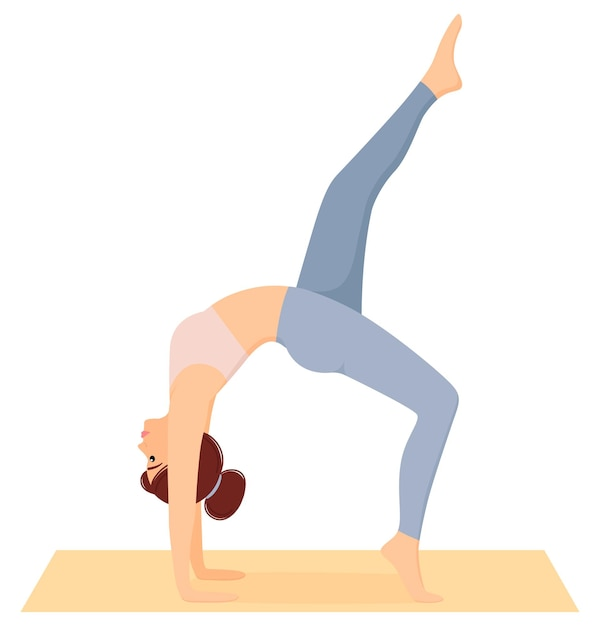

In [18]:
# Display the first image in the dataset
dataset[0]["image"]

In [19]:

labels_subset = y['label'][:5].tolist()
print(labels_subset)


labels=y['label'].tolist()

['Bridge-Pose', 'Bridge-Pose', 'Bridge-Pose', 'Bridge-Pose', 'Bridge-Pose']


In [20]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(labels)))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Bridge-Pose', 1: 'Child-Pose', 2: 'Cobra-Pose', 3: 'Downward-Dog-Pose', 4: 'Pigeon-Pose', 5: 'Standing-Mountain-Pose', 6: 'Tree-Pose', 7: 'Triangle-Pose', 8: 'Warrior-Pose'} 

Mapping of Labels to IDs: {'Bridge-Pose': 0, 'Child-Pose': 1, 'Cobra-Pose': 2, 'Downward-Dog-Pose': 3, 'Pigeon-Pose': 4, 'Standing-Mountain-Pose': 5, 'Tree-Pose': 6, 'Triangle-Pose': 7, 'Warrior-Pose': 8}


In [21]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/3006 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3006 [00:00<?, ? examples/s]

In [22]:

model_str = 'google/vit-base-patch16-224-in21k'

processor = ViTImageProcessor.from_pretrained(model_str)


image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)


_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(40),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)


def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [23]:

train_data.set_transform(train_transforms)


test_data.set_transform(val_transforms)

In [24]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.805577


In [26]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [27]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "yoga_pose_image_classification"

# Define the number of training epochs for the model.
num_train_epochs = 10

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=2e-6,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=64,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=32,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none"
)

In [27]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [28]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 0.29641470313072205,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9617622610141313,
 'eval_runtime': 540.507,
 'eval_samples_per_second': 2.226,
 'eval_steps_per_second': 0.07}

In [29]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.296346,0.003000,0.961762
2,No log,0.294925,0.003000,0.961762
3,No log,0.294881,0.003000,0.962594
4,No log,0.292089,0.003000,0.961762
5,No log,0.291811,0.003000,0.962594
6,No log,0.292317,0.003000,0.960931
7,No log,0.290601,0.003000,0.961762
8,No log,0.290150,0.003000,0.962594
9,No log,0.289915,0.003000,0.962594
10,No log,0.289684,0.003000,0.962594


TrainOutput(global_step=290, training_loss=0.31361260249696926, metrics={'train_runtime': 29316.2325, 'train_samples_per_second': 0.615, 'train_steps_per_second': 0.01, 'total_flos': 1.397268230163886e+18, 'train_loss': 0.31361260249696926, 'epoch': 10.0})

In [30]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.289683997631073,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9625935162094763,
 'eval_runtime': 533.7662,
 'eval_samples_per_second': 2.254,
 'eval_steps_per_second': 0.071,
 'epoch': 10.0}

In [31]:
trainer.save_model(output_dir='./resultss')
processor.save_pretrained('./resultss')

['./resultss\\preprocessor_config.json']

In [23]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.2868703603744507, 'test_accuracy': 0.9675810473815462, 'test_runtime': 17.841, 'test_samples_per_second': 67.429, 'test_steps_per_second': 2.13}


Accuracy: 0.9676
F1 Score: 0.9677


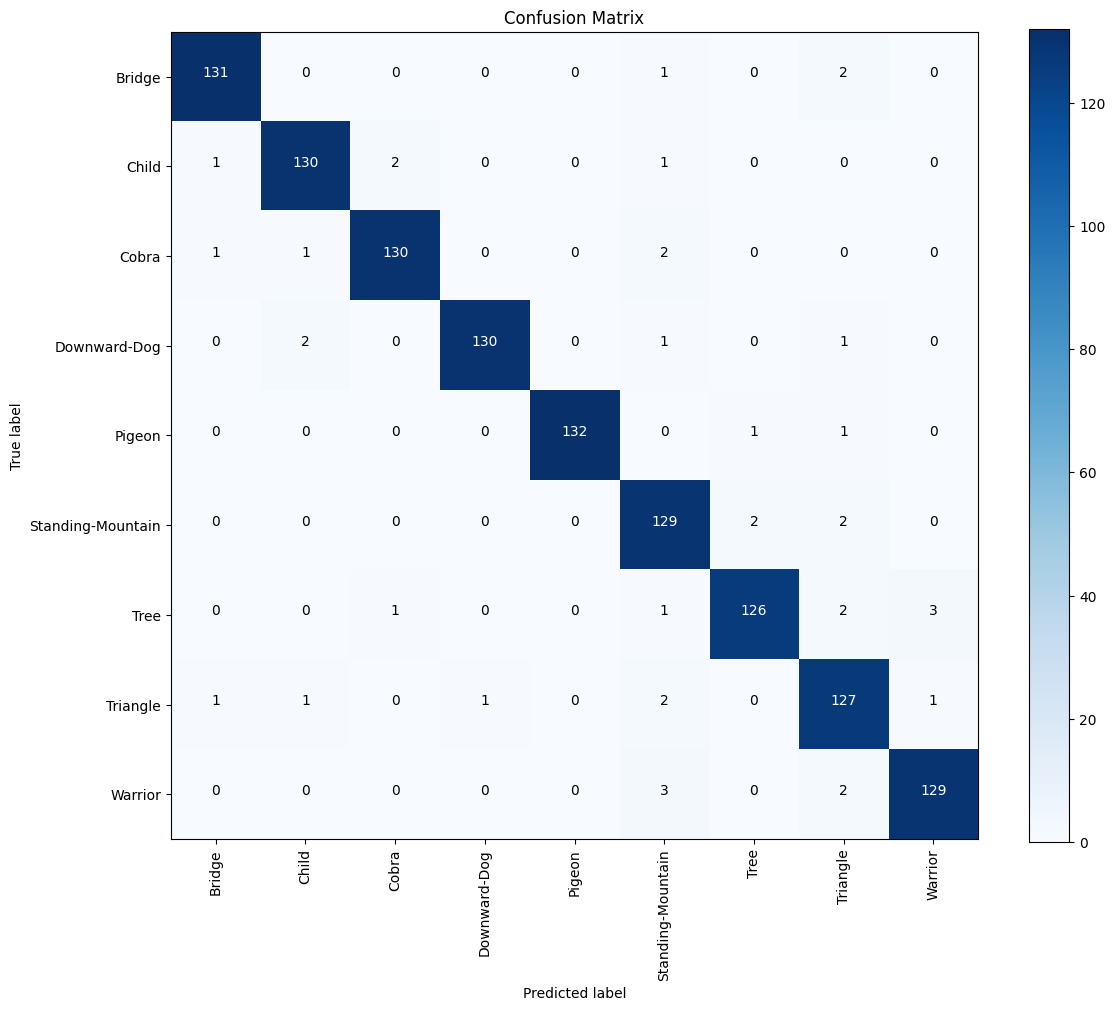


Classification report:

                   precision    recall  f1-score   support

           Bridge     0.9776    0.9776    0.9776       134
            Child     0.9701    0.9701    0.9701       134
            Cobra     0.9774    0.9701    0.9738       134
     Downward-Dog     0.9924    0.9701    0.9811       134
           Pigeon     1.0000    0.9851    0.9925       134
Standing-Mountain     0.9214    0.9699    0.9451       133
             Tree     0.9767    0.9474    0.9618       133
         Triangle     0.9270    0.9549    0.9407       133
          Warrior     0.9699    0.9627    0.9663       134

         accuracy                         0.9676      1203
        macro avg     0.9681    0.9676    0.9677      1203
     weighted avg     0.9681    0.9676    0.9677      1203



In [24]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

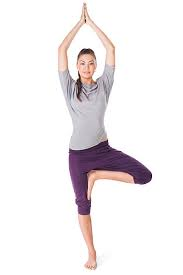

In [29]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [30]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]

'Tree-Pose'

In [31]:
# load trained  model
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()


In [32]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data):
        # Initialize with your data
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return a single data point
        return self.data[idx]

# Create your dataset
test_dataset = MyDataset(test_data)

# Create DataLoader (if needed)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [33]:
from transformers import ViTForImageClassification, Trainer, TrainingArguments

model = ViTForImageClassification.from_pretrained('./resultss')



In [34]:
training_args = TrainingArguments(
    output_dir='./resultss',
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
)

trainer1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Replace with your actual training dataset
    eval_dataset=test_data    # Replace with your actual evaluation dataset
)


In [35]:
# Predict using the trainer
outputs = trainer1.predict(test_dataset)
print(outputs.metrics)

{'test_loss': 0.29606449604034424, 'test_model_preparation_time': 0.004, 'test_runtime': 693.2793, 'test_samples_per_second': 1.735, 'test_steps_per_second': 0.218}


Accuracy: 0.9634
F1 Score: 0.9635


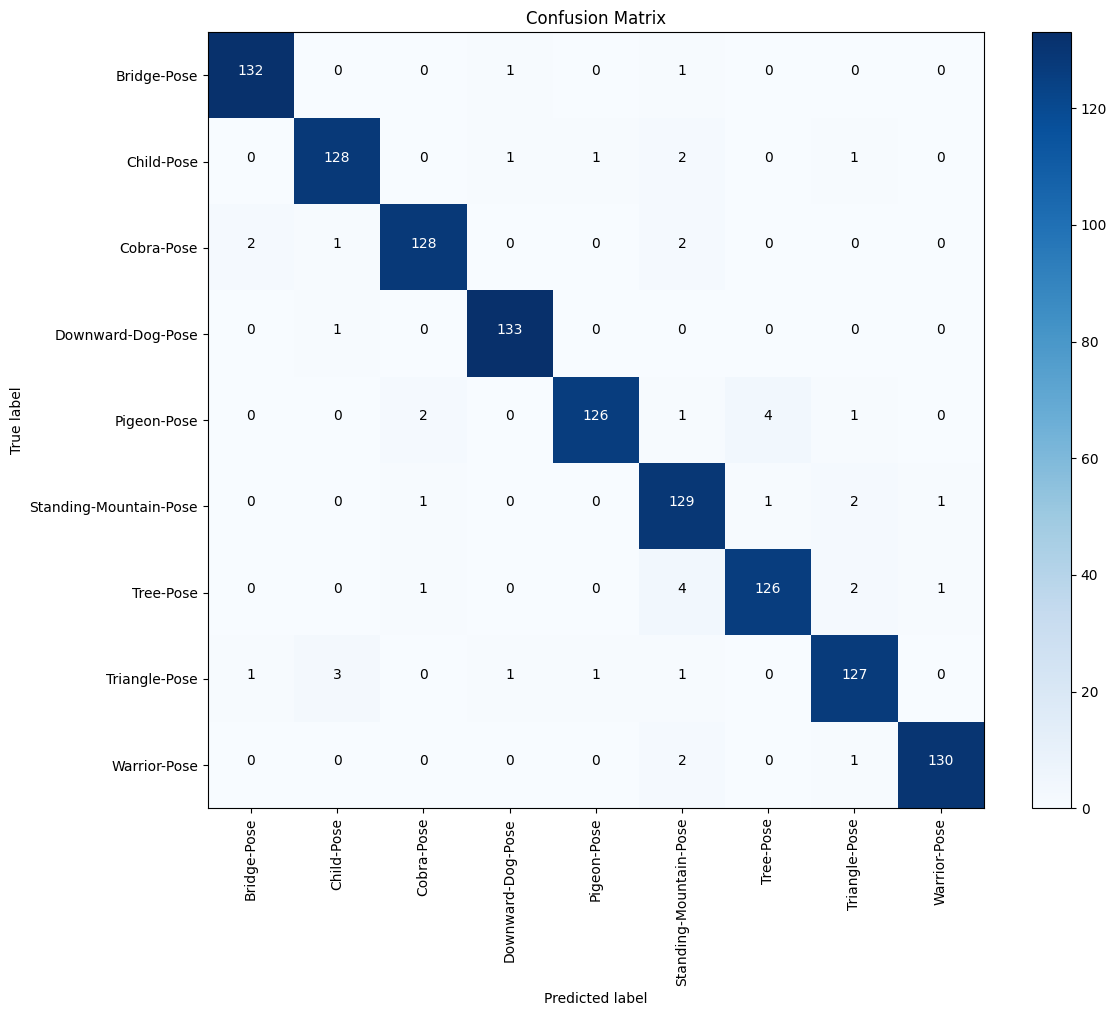


Classification report:

                        precision    recall  f1-score   support

           Bridge-Pose     0.9778    0.9851    0.9814       134
            Child-Pose     0.9624    0.9624    0.9624       133
            Cobra-Pose     0.9697    0.9624    0.9660       133
     Downward-Dog-Pose     0.9779    0.9925    0.9852       134
           Pigeon-Pose     0.9844    0.9403    0.9618       134
Standing-Mountain-Pose     0.9085    0.9627    0.9348       134
             Tree-Pose     0.9618    0.9403    0.9509       134
         Triangle-Pose     0.9478    0.9478    0.9478       134
          Warrior-Pose     0.9848    0.9774    0.9811       133

              accuracy                         0.9634      1203
             macro avg     0.9639    0.9634    0.9635      1203
          weighted avg     0.9639    0.9634    0.9635      1203



In [36]:
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [37]:
from torchvision import transforms

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size expected by the model
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])
from transformers import AutoModelForImageClassification

# Path to the directory where the model is saved
model_dir = './resultss'

# Load the model for image classification
model = AutoModelForImageClassification.from_pretrained(model_dir)


In [38]:
from PIL import Image
import torch
import torch.nn.functional as F
# Function to classify an image and get probabilities
def classify_image(image_path, model, transform):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Apply the transformations
    image = transform(image)
    
    # Add batch dimension
    image = image.unsqueeze(0)
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Perform the prediction
    with torch.no_grad():
        outputs = model(image)
    
     # Apply softmax to get probabilities
    probabilities = F.softmax(outputs.logits, dim=1).squeeze()

    # Get the class with the highest probability
    predicted_class = torch.argmax(probabilities).item()
    predicted_probability = probabilities[predicted_class].item()
    
    return probabilities, predicted_class, predicted_probability


# Example usage: Classify an image
image_path1=r"C:\Users\Manveen\PycharmProjects\AsanaBot\yoga-pose-classification-dataset\Tree-Pose\images153.jpg"
image_path = r"C:\Users\Manveen\PycharmProjects\AsanaBot\yoga-pose-classification-dataset\Bridge-Pose\image16.jpeg"
probabilities, predicted_class, predicted_probability = classify_image(image_path1, model, transform)
for i, prob in enumerate(probabilities):
    print(f"Class {id2label[i]}: {prob*100:.2f}%")


print(f"Predicted class: {id2label[predicted_class]} with probability {predicted_probability:.2%}")

Class Bridge-Pose: 2.65%
Class Child-Pose: 3.72%
Class Cobra-Pose: 2.82%
Class Downward-Dog-Pose: 2.75%
Class Pigeon-Pose: 4.24%
Class Standing-Mountain-Pose: 7.27%
Class Tree-Pose: 65.83%
Class Triangle-Pose: 4.97%
Class Warrior-Pose: 5.76%
Predicted class: Tree-Pose with probability 65.83%
